In [64]:
!pip install scikit-optimize
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.metrics import mean_squared_error
import numpy as np

In [82]:
df = pd.read_csv('Advertising.csv')
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


#Punto 1

In [83]:
X = df[["TV", "radio", "newspaper"]]
y = df["sales"]

In [84]:
X_const = sm.add_constant(X)


ols_model = sm.OLS(y, X_const).fit()

y_pred = ols_model.predict(X_const)
resid = ols_model.resid

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.58e-96
Time:                        23:34:27   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

Newspaper no es relevante por el alto p-value

#Punto 2

In [85]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

search_spaces_xgb = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(2, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

opt_xgb = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces_xgb,
    n_iter=30,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)


opt_xgb.fit(X, y)

print("Mejores hiperparámetros encontrados:")
print(opt_xgb.best_params_)


best_model = opt_xgb.best_estimator_
y_pred = best_model.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print(f"MSE del mejor modelo: {mse:.4f}")
print(f"RMSE del mejor modelo: {rmse:.4f}")
print(f"R² del mejor modelo: {best_model.score(X, y):}")

Mejores hiperparámetros encontrados:
OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.0367000660955683, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.5})
MSE del mejor modelo: 0.0869
RMSE del mejor modelo: 0.2948
R² del mejor modelo: 0.9967920183748286


#Punto 3

## No linealidad

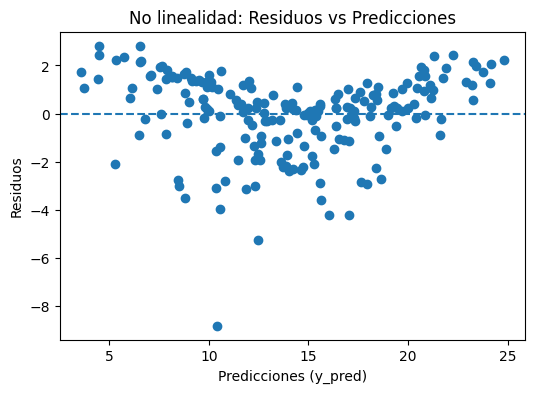

In [21]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred, resid)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicciones (y_pred)")
plt.ylabel("Residuos")
plt.title("No linealidad: Residuos vs Predicciones")
plt.show()


En la gráfica podemos observar una curva y justo es lo que nos dice que si definitivamente no tiene linealidad así que tendremos que hacer cambios. Se pueden hacer interacciones o también elevar al cuadrado.

##Correlación de residuos

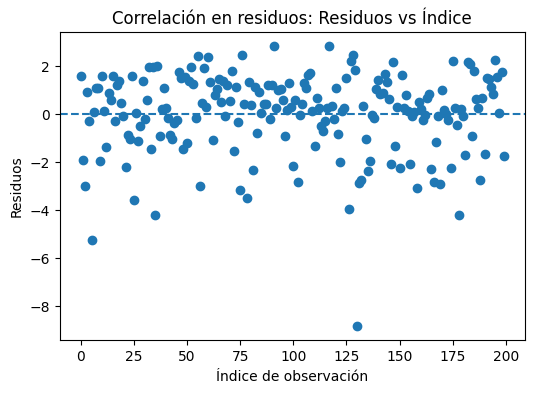

In [30]:
plt.figure(figsize=(6,4))
plt.plot(resid, marker='o', linestyle='')
plt.axhline(0, linestyle='--')
plt.xlabel("Índice de observación")
plt.ylabel("Residuos")
plt.title("Correlación en residuos: Residuos vs Índice")
plt.show()


En el gráfico no se aprecia un patrón definido ni rachas persistentes de residuos. La distribución se observa aleatoria.

## No varianza constante

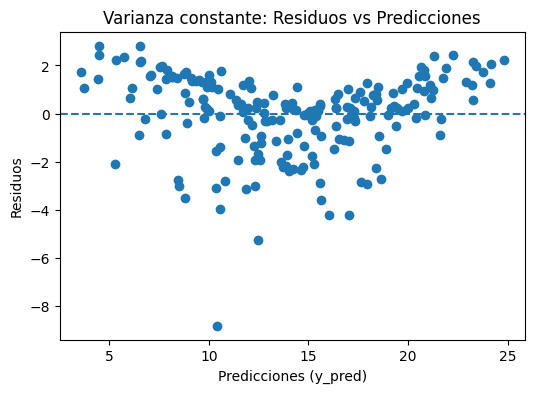

In [32]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred, resid)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicciones (y_pred)")
plt.ylabel("Residuos")
plt.title("Varianza constante: Residuos vs Predicciones")
plt.show()


En la gráfica podemos observar que no se dispensar igual para todas las predicciones, hay una forma más estrecha en el centro y más dispersa en los extremos. La varianza no se observa constante y para corregirlo se añadieron términos polinómicos anteriormente para arreglar la linealización (no se si así se diga) y con eso también se buca estabilizar la varianza de los errores.

## Outliers

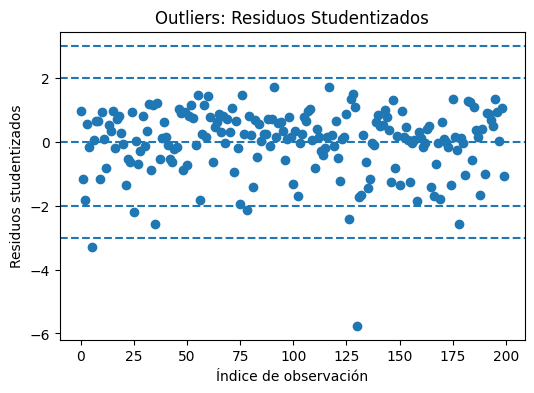

Posibles outliers (|residuo studentizado| > 3): [  5 130]


In [24]:
influence = ols_model.get_influence()
student_resid = influence.resid_studentized_external

plt.figure(figsize=(6,4))
plt.plot(student_resid, marker='o', linestyle='')
plt.axhline(0, linestyle='--')
plt.axhline(2, linestyle='--')
plt.axhline(-2, linestyle='--')
plt.axhline(3, linestyle='--')
plt.axhline(-3, linestyle='--')
plt.xlabel("Índice de observación")
plt.ylabel("Residuos studentizados")
plt.title("Outliers: Residuos Studentizados")
plt.show()

outliers_idx = np.where(np.abs(student_resid) > 3)[0]
print("Posibles outliers (|residuo studentizado| > 3):", outliers_idx)


Si hay dos puntos outliers que son los que pasan los 3 puntos cuando estudentizamos y los vamos a borrar.

## High leverage points

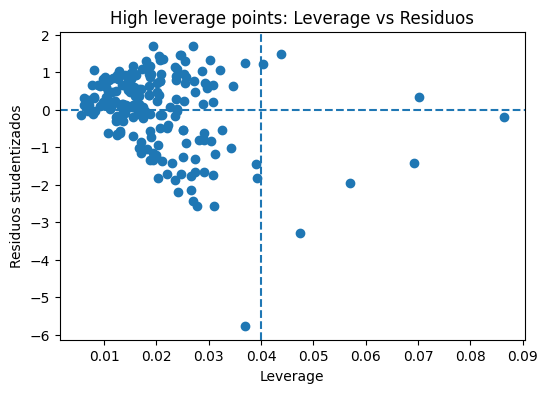

Puntos de alto leverage: [  5  16  36  75 101 128 165]


In [26]:
leverage = influence.hat_matrix_diag

plt.figure(figsize=(6,4))
plt.scatter(leverage, student_resid)
plt.xlabel("Leverage")
plt.ylabel("Residuos studentizados")
plt.title("High leverage points: Leverage vs Residuos")
plt.axhline(0, linestyle='--')

n = X_const.shape[0]
p = X_const.shape[1] - 1
lev_threshold = 2 * (p + 1) / n
plt.axvline(lev_threshold, linestyle='--')
plt.show()

high_lev_idx = np.where(leverage > lev_threshold)[0]
print("Puntos de alto leverage:", high_lev_idx)


Si se identificaron puntos con alto leverage, como se puede ver la gráfica. Se decidió mantener esos puntos ya que tienden a tener una gran importancia.

##Colinealidad

    variable       VIF
0      const  6.848900
1         TV  1.004611
2      radio  1.144952
3  newspaper  1.145187


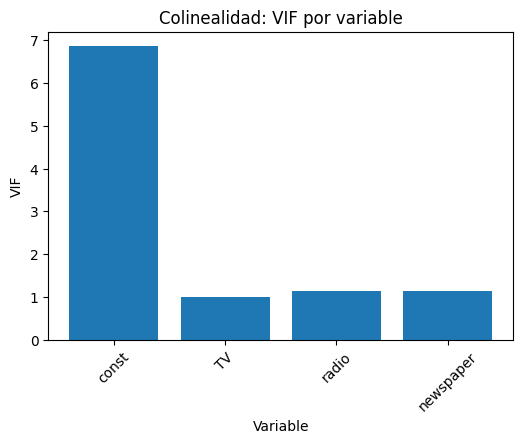

In [27]:
vif_data = []

for i in range(X_const.shape[1]):
    vif = variance_inflation_factor(X_const.values, i)
    vif_data.append(vif)

vif_df = pd.DataFrame({
    "variable": X_const.columns,
    "VIF": vif_data
})

print(vif_df)

plt.figure(figsize=(6,4))
plt.bar(vif_df["variable"], vif_df["VIF"])
plt.xlabel("Variable")
plt.ylabel("VIF")
plt.title("Colinealidad: VIF por variable")
plt.xticks(rotation=45)
plt.show()


En el libro salía que si se tenía un VIF arriba de 5 era probable la colinealidad, todos los valores se situaron entre 1 y 2, por lo que no hay colinealidad significativa entre los predictores.

##Como resolver estos problemas

In [86]:
df_clean = df.drop(index=outliers_idx)
df_clean = df_clean.drop('newspaper', axis=1)

df_clean["TV2"] = df_clean["TV"]**2
df_clean["TV_radio"] = df_clean["TV"] * df_clean["radio"]

X = df_clean[["TV", "TV2", "radio", "TV_radio"]]
y = df_clean["sales"]

#Punto 4

In [87]:
X_const = sm.add_constant(X)

ols_corrected = sm.OLS(y, X_const).fit()

print(ols_corrected.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     5150.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          7.25e-195
Time:                        23:36:10   Log-Likelihood:                -141.48
No. Observations:                 198   AIC:                             293.0
Df Residuals:                     193   BIC:                             309.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1660      0.155     33.348      0.0

#Punto 5

In [88]:
df_clean["TV3"] = df_clean["TV"]**3
df_clean["radio2"] = df_clean["radio"]**2
df_clean["radio3"] = df_clean["radio"]**3

X = df_clean[[
    "TV", "TV2", "TV3",
    "radio", "radio2", "radio3",
    "TV_radio"
]]

y = df_clean["sales"]


In [89]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

search_spaces_xgb = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(2, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

opt_xgb = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces_xgb,
    n_iter=30,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

opt_xgb.fit(X, y)

print("Mejores hiperparámetros encontrados:")
print(opt_xgb.best_params_)

best_model = opt_xgb.best_estimator_

y_pred = best_model.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print("=== RESULTADOS DEL MEJOR MODELO XGBOOST ===")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {best_model.score(X, y):.4f}")

Mejores hiperparámetros encontrados:
OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.05355606091896173, 'max_depth': 2, 'n_estimators': 321, 'subsample': 0.5})
=== RESULTADOS DEL MEJOR MODELO XGBOOST ===
MSE : 0.0425
RMSE: 0.2061
R²  : 0.9984


#Punto 6

Si comparamos el modelo lineal de OLS en el punto 1 tuvimos una R^2 de 0.897 y con los cambio que se aplicaron en el punto 4 se observa R^2 de 0.991.

Entre los cambios que hicimos para poder mejorar la predicción del modelo, se eliminaron 2 outliers, se agregó estructura no lineal, se eliminó newspaper ya que tenía un p-value no signnificativo. Se identificaron high leverage points pero se mantuvieron.

En los modelos no lineales (XGBoost) en el punto 2 me dio un R^2 de 0.9968 y en el punto 0.9984.

Incluso sin modificaciones, XGBoost ya superaba ampliamente el modelo debido a su capacidad para aprender relaciones no lineales de manera automática.

Lo que podemos concluir de todo esto es que comprender y diagnosticar los problemas del dataset es tan importante como el algoritmo utilizado. Podemos observar como nuestros modelos mejoran significativamente.